# O Teorema de Tellegen

Date: 2022-09-27  
Author: Pedro H. N. Vieira  
Categories: tellegen, circuitos  
Tags: python, tellegen, circuitos  
<!--eofm-->

Seja um circuito elétrico (grafo direcionado) qualquer com $N$ nós (vértices) e $M$ elementos (arestas). A matriz de incidência $B$ dele tem dimensão $(N \times M)$, cujo valor na linha $n$ e coluna $k$ é definido como:

$$B_{nk} = +1 \text{ se $n$ é o nó positivo do elemento $k$}$$
$$B_{nk} = -1 \text{ se $n$ é o nó negativo do elemento $k$}$$
$$B_{nk} = 0 \text{ de outra maneira}$$

Um [espaço nulo (ou núcleo)](https://pt.wikipedia.org/wiki/Núcleo_(álgebra_linear)) da matriz $B$ nos fornece a matriz $C$ de laço fundamental do circuito, isto é, uma matriz cujos elementos $C_{ck}$ são dados pela relação

$$C_{ck} = +1 \text{ se o caminho $c$ passa pelo elemento $k$ no sentido de sua polaridade}$$
$$C_{ck} = -1 \text{ se o caminho $c$ passa pelo elemento $k$ no sentido inverso de sua polaridade}$$
$$C_{ck} = 0 \text{ se o caminho $c$ não inclui o elemento $k$}$$

O número de linhas da matriz $C$ é igual à quantidade mínima de caminhos necessários para passar por todos os elementos do circuito com a restrição de que cada nó só pode ser visitado uma única vez por caminho.

A Lei de Kirchhoff das Correntes pode ser expressa em forma matricial como

$$
B \cdot I_e = \mathbf{0}
$$

onde $I_e$ é o vetor de correntes nos elementos e $\mathbf{0}$ é um vetor de zeros.
 A matriz $C$ define a Lei de Kirchhoff das Tensões para todo o circuito matricialmente

$$
C \cdot V_e = \mathbf{0}
$$

onde $V_e$ é o vetor de tensões sobre os elementos, que está relacionado ao vetor de potenciais nodais $V_n$ pela seguinte equação:

$$
V_e = B^T \cdot V_n
$$

Escrevendo o balanço de energia do circuito, tem-se a seguinte equação

$$
V_e^T \cdot I_e = 0
$$

expressando $V_e$ em termos de $V_n$ e substituindo:

$$
(B^T \cdot V_n)^T \cdot I_e = 0
$$

utilizamos a identidade matricial $(A \cdot B)^T = B^T \cdot A^T$ para reescrever a equação como

$$
V_n^T \cdot B \cdot I_e = 0
$$

Note, contudo, que $B \cdot I_e = \mathbf{0}$ é a Lei de Kirchhoff das Correntes e a equação acima será verdadeira para quaisquer valores de potenciais nodais e, portanto, quaisquer valores de tensões nos elementos. Assim, deduzimos o Teorema de Tellegen.

**Teorema de Tellegen:** Sejam dois circuitos $\alpha$ e $\beta$ com uma topologia idêntica, isto é, mesma matriz de incidência $B$, que satisfazem ambas as Leis de Kirchhoff. Multiplicar as tensões nos elementos de um circuito pelas correntes nos elementos no outro satisfaz a equação de balanço de energia, ou seja,

$$
V_{e \alpha}^T \cdot I_{e \beta} = V_{e \beta}^T \cdot I_{e \alpha} = 0
$$

Para testar este teorema, vamos criar dois circuitos com topologia igual (abaixo), mas com tipo e valores aleatórios para os elementos. Confira o [*post* sobre Análise Nodal Modificada](https://comp-eletromag.netlify.app/post/analise_nodal_modificada/) em como criar um programa para simular circuitos resistivos. O elemento `E1` poderá ser tanto uma fonte de tensão quanto uma de corrente. Os outros elementos serão resistores.

In [1]:
from copy import deepcopy
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import schemdraw
import schemdraw.elements as elm

In [2]:
class Elemento(object):
    def __init__(self, no1, no2, valor, nome=""):  # esse é o construtor do objeto
        if no1 < 0 or no2 < 0:
            raise ValueError("O nó deve ser um valor não negativo.")
            
        self.no1 = no1
        self.no2 = no2
        self.valor = valor
        self.nome = nome
      
    
    def __repr__(self):  # esse é o "print" do objeto
        s = type(self).__name__ + self.nome + " de valor " + str(self.valor)
        s += " do nó " + str(self.no1) + " para o nó " + str(self.no2)
        return s
    
    
    def carimbar(self, Y, I, nn):
        return None
        

class Resistor(Elemento):
    def __init__(self, no1, no2, valor, nome=""):
        if valor <= 0.0:
            raise ValueError("Resistor deve ter um valor positivo.")
            
        super().__init__(no1, no2, valor, nome)
       
    
    def carimbar(self, Y, I=None, nn=None):
        no1 = self.no1 - 1
        no2 = self.no2 - 1
        admitancia = 1.0 / self.valor
        if no1 >= 0:
            Y[no1, no1] += admitancia
            
        if no2 >= 0:
            Y[no2, no2] += admitancia
            
        if no1 >= 0 and no2 >= 0:
            Y[no1, no2] += -admitancia
            Y[no2, no1] = Y[no1, no2]
        
        
class Fonte_Corrente(Elemento):
    def __init__(self, no1, no2, valor, nome=""):
        super().__init__(no1, no2, valor, nome)
        
    
    def carimbar(self, Y, I, nn=None):
        no1 = self.no1 - 1
        no2 = self.no2 - 1
        if no1 >= 0:
            I[no1] += -self.valor
            
        if no2 >= 0:
            I[no2] += self.valor
            
        
class Fonte_Tensao(Elemento):
    def __init__(self, no1, no2, valor, indice, nome=""):
        if indice < 1:
            raise ValueError("indice deve ser um valor positivo.")
            
        super().__init__(no1, no2, valor, nome)
        self.indice = indice
        
    
    def carimbar(self, Y, I, nn):
        no1 = self.no1 - 1
        no2 = self.no2 - 1
        e = self.indice
        I[(nn - 1 + e)] = self.valor
        if no1 >= 0:
            Y[no1, (nn - 1 + e)] = -1
            Y[(nn - 1 + e), no1] = 1
            
        if no2 >= 0:
            Y[no2, (nn - 1 + e)] = 1
            Y[(nn - 1 + e), no2] = -1
            
        if no1 >= 0 and no2 >= 0:
            Y[id1, id2] += -1
            Y[id2, id1] = Y[id1, id2]
            
            
def maior_no(netlist):
    m = 0
    for elemento in netlist:
        if elemento.no1 > m:
            m = elemento.no1
            
        if elemento.no2 > m:
            m = elemento.no2
    
    return m


def montar_resolver(netlist):
    nn = maior_no(netlist)
    nv = 0  # número de fontes de tensão
    for elemento in netlist:
        if type(elemento) == type(Fonte_Tensao(0,1,1,1)):
            nv += 1
    
    m = nv + nn
    Y = np.zeros((m, m))
    I = np.zeros((m,))
    for elemento in netlist:
        elemento.carimbar(Y, I, nn)

    V = np.linalg.solve(Y, I)
    return V


def calcular_tensoes(netlist, V):
    vr = np.zeros(len(netlist))
    for i in range(len(netlist)):
        elem = netlist[i]
        no1 = elem.no1 - 1
        no2 = elem.no2 - 1
        if no1 >= 0:
            v1 = V[no1]
        else:
            v1 = 0
            
        if no2 >= 0:
            v2 = V[no2]
        else:
            v2 = 0
            
        vr[i] = v1 - v2
    
    return vr


def calcular_correntes(netlist, V):
    I = np.zeros(len(netlist))
    nn = maior_no(netlist)
    vr = calcular_tensoes(netlist, V)
    for i in range(len(netlist)):
        elem = netlist[i]
        if type(elem) == type(Fonte_Tensao(0,1,1,1)):
            I[i] = -V[nn + elem.indice - 1]
            
        elif type(elem) == type(Fonte_Corrente(0,1,1)):
            I[i] = elem.valor
            
        elif type(elem) == type(Resistor(0,1,1)):
            I[i] = vr[i] / elem.valor
            
        else:
            print("tipo de elemento não reconhecido")
            
    return I

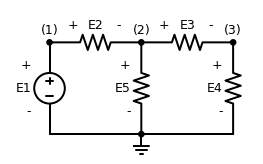

In [3]:
with schemdraw.Drawing() as d:
    d += (I := elm.SourceV().up().label(('-', 'E1', '+')))
    d += (R1 := elm.Resistor().right().label(('+', 'E2', '-')))
    d += (R2 := elm.Resistor().right().label(('+', 'E3', '-')))
    d += (R3 := elm.Resistor().down().label(('+', 'E4', '-')))
    d += elm.Line().left()
    d += (R4 := elm.Resistor().up().label(('-', 'E5', '+')))
    d += elm.Line().endpoints(I.start, R4.start)
    d += elm.Ground()
    d += elm.Dot().at(R1.start).label("(1)")
    d += elm.Dot().at(R1.end).label("(2)")
    d += elm.Dot().at(R2.end).label("(3)")
    d += elm.Dot().at(R4.start)

In [4]:
def aleatorizar_netlist(netlist, sigma=1, mu=0):
    for i in range(len(netlist)):
        x = sigma * np.random.randn() + mu  # curva normal
        netlist[i].valor = abs(x)
        
        
netlist1 = [
    Fonte_Tensao(1, 0, 1, 1),
    Resistor(1, 2, 1),
    Resistor(2, 3, 1),
    Resistor(2, 0, 1),
    Resistor(3, 0, 1),
]
netlist2 = deepcopy(netlist1)
netlist2[0] = Fonte_Corrente(netlist1[0].no1, netlist1[0].no2, 1)

aleatorizar_netlist(netlist1)
aleatorizar_netlist(netlist2)

In [5]:
netlist1

[Fonte_Tensao de valor 1.004918623765807 do nó 1 para o nó 0,
 Resistor de valor 0.45595843222097066 do nó 1 para o nó 2,
 Resistor de valor 1.3579302127694999 do nó 2 para o nó 3,
 Resistor de valor 0.6642740153458906 do nó 2 para o nó 0,
 Resistor de valor 1.369966643708558 do nó 3 para o nó 0]

In [6]:
netlist2

[Fonte_Corrente de valor 0.23682922711739327 do nó 1 para o nó 0,
 Resistor de valor 0.9552080791907799 do nó 1 para o nó 2,
 Resistor de valor 1.7358451654136247 do nó 2 para o nó 3,
 Resistor de valor 0.27022400294699417 do nó 2 para o nó 0,
 Resistor de valor 1.6143699333837873 do nó 3 para o nó 0]

Resolver os circuitos e testar o Teorema de Tellegen:

In [7]:
nn = maior_no(netlist1)
V1 = montar_resolver(netlist1)
V2 = montar_resolver(netlist2)
vr1 = calcular_tensoes(netlist1, V1)
vr2 = calcular_tensoes(netlist2, V2)
ir1 = calcular_correntes(netlist1, V1)
ir2 = calcular_correntes(netlist2, V2)

In [8]:
print(vr1.T.dot(ir1))
print(vr2.T.dot(ir2))
print(vr1.T.dot(ir2))
print(vr2.T.dot(ir1))

-5.551115123125783e-17
2.0166160408230382e-17
-2.2551405187698492e-17
2.862293735361732e-17


# Referências

<a name="1"></a>[1] NAJM, Farid N. **Circuit simulation**. John Wiley & Sons, 2010.

<a name="1"></a>[2] PENFIELD, Paul; SPENCE, Robert; DUINKER, Simon. A generalized form of Tellegen's theorem. **IEEE Transactions on Circuit Theory**, v. 17, n. 3, p. 302-305, 1970.